1. Compute the gradient and Hessians of the loss function for linear regression with L2 regularization.

We take the derivative of the loss function with respect to $w'$ and get:
$$ \frac{\partial f(w')}{\partial w'} = \frac{1}{n} \sum_{i=1}^{n} -y_i x_i \frac{\exp(-y_i w^T x_i)}{1 + \exp(-y_i w^T x_i)} + 2\lambda w$$

Hence, the gradient is equal to:
$$ \nabla_{w'} f(w') = \frac{1}{n} \sum_{i=1}^{n} -y_i x_i \frac{\exp(-y_i w^T x_i)}{1 + \exp(-y_i w^T x_i)} + 2\lambda w$$

We then take the derivative of the gradient with respect to $w'$ and get:
$$ \frac{\partial^2 f(w')}{\partial w'^2} = \frac{\partial \nabla_{w'} f(w')}{\partial w'} = \frac{1}{n} \sum_{i=1}^{n} y_i^2 x_i^2 \frac{\exp(-y_i w^T x_i)}{(1 + \exp(-y_i w^T x_i))^2} + 2\lambda I$$

Hence, the Hessians is equal to:
$$\nabla^2_{w'} f(w') = \frac{1}{n} \sum_{i=1}^{n} y_i^2 x_i^2 \frac{\exp(-y_i w^T x_i)}{(1 + \exp(-y_i w^T x_i))^2} + 2\lambda I$$

In [1]:
#2. Empirically verify the correctness
import torch
import sklearn
from sklearn import datasets

#import breast cancer dataset
brest_cancer = datasets.load_breast_cancer()
X = brest_cancer.data
y = brest_cancer.target
y = y.reshape(-1,1)
#convert numpy array to torch tensor
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

#init tensor w as a vector
omega = torch.ones(X.shape[1],1,requires_grad=True) #w = [1...1]
bias = torch.ones(1,1,requires_grad=True)       #w0 = 1

#evaluate the gradients of f in part 1
def f(X, y, omega, bias):
    ll = 1
    #compute the loss
    loss = torch.sum(torch.log(1 + torch.exp(-y * (torch.matmul(X, omega) + bias))))*1/X.shape[0] + ll*torch.norm(omega)**2
    return loss

torchOmegaGrad = torch.autograd.grad(f(X, y, omega, bias), omega, create_graph=True)[0]
torchBiasGrad = torch.autograd.grad(f(X, y, omega, bias), bias, create_graph=True)[0]

# $$ \nabla_{w'} f(w') = \frac{1}{n} \sum_{i=1}^{n} -y_i x_i \frac{\exp(-y_i w^T x_i)}{1 + \exp(-y_i w^T x_i)} + 2\lambda w$$
myOmegaGrad = torch.sum(-y * X * torch.exp(-y * (torch.matmul(X, omega) + bias)) / (1 + torch.exp(-y * (torch.matmul(X, omega) + bias))), dim=0, keepdim=True).T/X.shape[0] + 2*omega
myBiasGrad = torch.sum(-y * torch.exp(-y * (torch.matmul(X, omega) + bias)) / (1 + torch.exp(-y * (torch.matmul(X, omega) + bias))), dim=0, keepdim=True).T/X.shape[0]

#compare the gradients in euclidean norm, which is the 2-norm
print("The difference between myOmegaGrad and torchOmegaGrad is: ", torch.norm(myOmegaGrad - torchOmegaGrad))
print("The difference between myBiasGrad and torchBiasGrad is: ", torch.norm(myBiasGrad - torchBiasGrad))

#compare the gradients in absolute value, which is the 1-norm
print("The difference between myOmegaGrad and torchOmegaGrad is: ", torch.norm(myOmegaGrad - torchOmegaGrad, p=1))
print("The difference between myBiasGrad and torchBiasGrad is: ", torch.norm(myBiasGrad - torchBiasGrad, p=1))


The difference between myOmegaGrad and torchOmegaGrad is:  tensor(0., grad_fn=<LinalgVectorNormBackward0>)
The difference between myBiasGrad and torchBiasGrad is:  tensor(0., grad_fn=<LinalgVectorNormBackward0>)
The difference between myOmegaGrad and torchOmegaGrad is:  tensor(0., grad_fn=<LinalgVectorNormBackward0>)
The difference between myBiasGrad and torchBiasGrad is:  tensor(0., grad_fn=<LinalgVectorNormBackward0>)


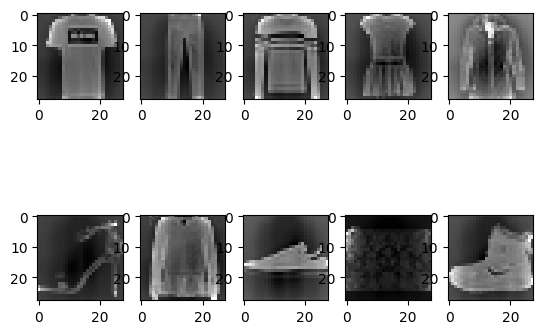

In [5]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, top_k_accuracy_score

# Load the MNIST reader
try:
	import mnist_reader
except ModuleNotFoundError:
	import sys
	sys.path.append("/utils")
	import mnist_reader

# Load the Fashion-MNIST dataset
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

# Preprocess the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Display one of each of the ten image classes in the training data set
fig, axs = plt.subplots(2, 5)
for i in range(10):
    axs[i//5, i%5].imshow(X_train[y_train == i][0].reshape(28, 28), cmap='gray')
plt.show()

# Fit a multiclass logistic regression model
clf = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=1000)
clf.fit(X_train, y_train)

# Predict the labels for train and test set
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Report the top-1 and top-3 classification accuracies and confusion matrices
print("Train accuracy:", np.mean(y_train == y_train_pred))
print("Test accuracy:", np.mean(y_test == y_test_pred))

print("Train top-3 accuracy:", top_k_accuracy_score(y_train, clf.predict_proba(X_train), k=3))
print("Test top-3 accuracy:", top_k_accuracy_score(y_test, clf.predict_proba(X_test), k=3))

print("Train confusion matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("Test confusion matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Find a misclassified image in the training data sets
misclassified_idx = np.where(y_train != y_train_pred)[0][0]
plt.imshow(X_train[misclassified_idx].reshape(28, 28), cmap='gray')
plt.title(f"True label: {y_train[misclassified_idx]}, Predicted label: {y_train_pred[misclassified_idx]}")
plt.show()
